# Подготовка данных для кредитного скоринга

Проект состоит в подготовке данных для кредитного отдела банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт возврата кредита в срок. Входные данные от банка &mdash; набор признаков клиентов с информацией об их платёжеспособности.

## Цель проекта

Проверить, действительно ли такие показатели как "количество детей" и "семейное положение" коррелируют с вероятностью невозврата кредита.

## Задачи проекта

- Подготовка данных: проверка данных на адекватность, выявление и заполнение пропусков в данных
- Выявление зависимостей кредитоспособности и целевых параметров
- Проверка альтернативных гипотез: какие ещё параметры могут предсказывать кредитоспособность

## Описание данных

- `children` — количество детей в семье
- `days_employed` — общий трудовой стаж в днях
- `dob_years` — возраст клиента в годах
- `education` — уровень образования клиента
- `education_id` — идентификатор уровня образования
- `family_status` — семейное положение
- `family_status_id` — идентификатор семейного положения
- `gender` — пол клиента
- `income_type` — тип занятости
- `debt` — имел ли задолженность по возврату кредитов
- `total_income` — ежемесячный доход
- `purpose` — цель получения кредита

In [1]:
!pip install -U scikit-learn
!pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.24.2)
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)


In [2]:
import warnings
from functools import reduce
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pymystem3 import Mystem

In [4]:
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:,.2f}'.format)

In [5]:
try:
    df = pd.read_csv("data.csv")
except FileNotFoundError:
    df = pd.read_csv("/datasets/data.csv")

## Обзор данных

Прежде всего проведём обзор данных (summery analysis). Посмотрим, какие данные есть, каких типов, есть ли пропуски.

In [6]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"-8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"-4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"-5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"-4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу


In [7]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,"21,525.00","19,351.00","21,525.00","21,525.00","21,525.00","21,525.00","19,351.00"
mean,0.54,"63,046.50",43.29,0.82,0.97,0.08,"167,422.30"
std,1.38,"140,827.31",12.57,0.55,1.42,0.27,"102,971.57"
min,-1.00,"-18,388.95",0.00,0.00,0.00,0.00,"20,667.26"
25%,0.00,"-2,747.42",33.00,1.00,0.00,0.00,"103,053.15"
50%,0.00,"-1,203.37",42.00,1.00,0.00,0.00,"145,017.94"
75%,1.00,-291.10,53.00,1.00,1.00,0.00,"203,435.07"
max,20.00,"401,755.40",75.00,4.00,4.00,1.00,"2,265,604.03"


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Обзор данных сразу указывает на странности: минимальное количество детей -1, а максимальное &mdash; 20. Минимальный трудовой стаж в днях -18388.949901 (-50 лет). Более того, у большей части клиентов стаж отрицательный, включая третью квартиль (-291). В тоже время максимальное значение положительно и абсурдно велико: 401755.4 дня, что соответсвует 1100 годам.

Имеются неявные пропуски: минимальный возраст 0 лет. 

Также видно, что присутствуют явные пропуски, по 2174 в колонках "стаж" и "доход". 

In [9]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [10]:
df["debt"].value_counts()

0    19784
1     1741
Name: debt, dtype: int64

Целевой показатель в норме: пропусков нет и количество клиентов с проблемами по погашению кредита выглядит не слишком большим и не очень маленьким: $8.8\%$

Целей кредита на удивление мало:

In [11]:
df["purpose"].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
жилье                                     647
покупка жилья                             647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
покупка своего жилья                      620
строительство недвижимости                620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

In [12]:
df["purpose"].nunique()

38

Всего 38 целей, что странно, если люди указывают цели самостоятельно, что называется "свободным вводом". А цель "ремонт жилью" наводит на мысль о синтетической природе данных: сложно представить, что люди независимо 612 раз одинаково описАлись. Тем не менее, 38 категорий "целей получения кредита" будет подспорьем в выделении дубликатов в условиях, когда нет надёжных ориентиров типа уникального id клиента или идентификатора заявки. 

### Вывод

В полученных данных выявлены проблемы: пропуски в колонках "стаж", "доход" и "возраст", также присутствуют ошибки в параметре "дети" и "стаж".

## Подготовка данных

Прежде чем мы начнём вносить изменения в данные, стоит избавиться от дубликатов. Дело в том, что наши заполнения, по определению не точные, могут создать иллюзию дубликатов: когда мы заполняем сходным образом пропуски просто "по аналогии", тогда как в реалности, значения могли быть пусть и близкие, но разные.

### Удаление дубликатов

Первым делом, посмотрим сколько дубликатов есть в сырых данных:

In [13]:
len(df[df.duplicated()])

54

In [14]:
df[df.duplicated()].head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,nan,41,среднее,1,женат / замужем,0,F,сотрудник,0,nan,покупка жилья для семьи
4182,1,nan,34,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,nan,свадьба
4851,0,nan,60,среднее,1,гражданский брак,1,F,пенсионер,0,nan,свадьба
5557,0,nan,58,среднее,1,гражданский брак,1,F,пенсионер,0,nan,сыграть свадьбу
7808,0,nan,57,среднее,1,гражданский брак,1,F,пенсионер,0,nan,на проведение свадьбы
8583,0,nan,58,высшее,0,Не женат / не замужем,4,F,пенсионер,0,nan,дополнительное образование
9238,2,nan,34,среднее,1,женат / замужем,0,F,сотрудник,0,nan,покупка жилья для сдачи
9528,0,nan,66,среднее,1,вдовец / вдова,2,F,пенсионер,0,nan,операции со своей недвижимостью
9627,0,nan,56,среднее,1,женат / замужем,0,F,пенсионер,0,nan,операции со своей недвижимостью
10462,0,nan,62,среднее,1,женат / замужем,0,F,пенсионер,0,nan,покупка коммерческой недвижимости


С одной стороны, дубликатов не много: $54$ на $21525$ клиентов ($0.25\%$) и столь небольшое количество строк можно безболезненно отбросить. С другой, настораживает, что все без исключения дубликаты имеют `NaN` в колонках `days_employed` и `total_income`, что намекает на недостаток данных: если бы эти параметры имели истинные значения, дублей, скорее всего, было бы меньше.

В нашей учебной ситуации при отсутствие коммуникации с поставщиками данных, мы не имеем возможности уточнить наши данные. Поэтому придётся принимать волевое решение, считать ли выявленные дубликаты дубликатами. С учётом их малочисленности, это решение вряд ли сильно повлияет на конечный результат, так что лучшим решением видится **сохранение данных**. В конце концов, накопленные данные имеют свою цену и отбрасывать их без веской причины расточительно.

#### Вывод

Было выявлено небольшое (54) количество дубликатов. В итоге было принято решение сохранить их в выборке.

Следующий шаг: переходим к анализу конкрентных значений признаков. В первую очередь, нас интересуют те параметры, по которым предполагается строить прогноз: "семейное положение" (`family_status`) и "дети" (`children`).

### Количество детей

Поскольку постановка задачи предполагает поиск связи целевого показателя (невозврат кредита) с количеством детей, с этого параметра и начнём. Построим распределение клиентов по количеству детей 

In [15]:
df["children"].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Странные значений здесь &mdash; -1 и 20.  Кажется разумным предположить, что в обоих случаях имел место "человеческий фактор": при заполнении данных о клиенте вместо 1 было введено -1 и 20 вместо 2. Видно, что клиентов с 6, 7, 8... детьми нет и семей с 20 детьми в 8 раз больше, чем с 5.

Альтернативой подобной замене может быть отбрасывание подозрительных значение. Это в принципе возможно, поскольку $76+47=123$ составляет чуть более $0.5\%$ от всего массива данных. Но, если мы стремимся к сбережению данных, пока это возможно, более предпочтительным было бы их сохранить и исправить на основе нашего предположения.

In [16]:
df.loc[df["children"] == -1, "children"] = 1
df.loc[df["children"] == 20, "children"] = 2

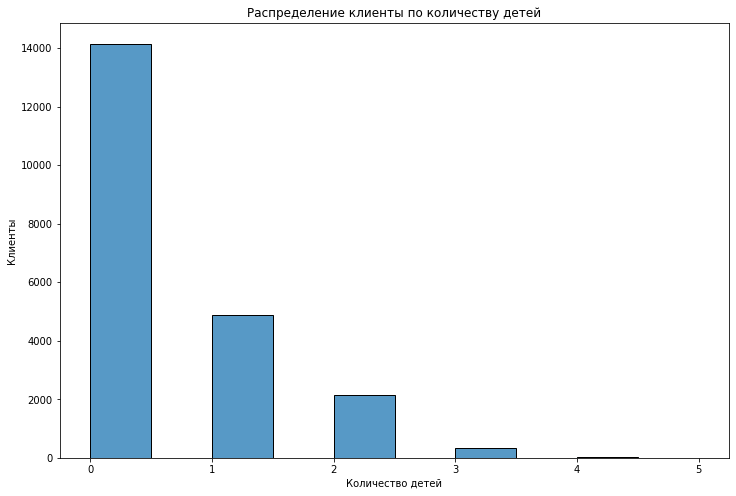

In [17]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

ax = sns.histplot(data=df["children"], binwidth=0.5)
ax.set_xlabel("Количество детей")
ax.set_ylabel("Клиенты")
ax.set_title("Распределение клиенты по количеству детей");

Это распределение уже больше похоже на правду.

#### Вывод

В параметре "количество детей" выли обнаружены два подозрительных значения -1 и 20. Они были исправлены в предполложении, что эти значения явились ошибками ввода данных и правильные значения &mdash; 1 и 2.

### Категориальные переменные

Ещё один предиктивный параметр в нашей задаче &mdash; семейное положение (`family_status`) &mdash; является категориальным. Ему уже поставлен в соответствие индекс (`family_status_id`). Так что строковое представление можно вынести из основной таблицы. Аналогичная ситуация и с образованием. Этот параметр не является целевым, но его влияние на возврат кредитов тоже можно проверить.

In [18]:
family_status_dict = (
    df[["family_status", "family_status_id"]].drop_duplicates().reset_index(drop=True)
)

family_status_dict.set_index("family_status_id", inplace=True)
family_status_dict

,family_status
family_status_id,
0,женат / замужем
1,гражданский брак
2,вдовец / вдова
3,в разводе
4,Не женат / не замужем


In [19]:
pd.set_option("mode.chained_assignment", None)
education_dict = df[["education", "education_id"]]
education_dict["education"] = education_dict["education"].str.lower()
education_dict = education_dict.drop_duplicates().reset_index(drop=True)

education_dict

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


In [20]:
df.groupby("education_id")["education"].count()

education_id
0     5260
1    15233
2      744
3      282
4        6
Name: education, dtype: int64

Ничего неожиданного: большинство со средним образованием, дальше довольно большая группа с высшим и клиентов с научными степенями всего несколько человек.  

Наконец, есть ещё категориальные признаки "тип занятости" (`income_type`) и пол (`gender`). Для них индексы нужно создать:

In [21]:
df.groupby("income_type")["income_type"].count()

income_type
безработный            2
в декрете              1
госслужащий         1459
компаньон           5085
пенсионер           3856
предприниматель        2
сотрудник          11119
студент                1
Name: income_type, dtype: int64

In [22]:
df["income_type"] = df["income_type"].astype("category")
df["income_type_id"] = df["income_type"].cat.codes

income_type_dict = df[["income_type_id", "income_type"]].drop_duplicates().reset_index(drop=True)
income_type_dict

,income_type_id,income_type
0,6,сотрудник
1,4,пенсионер
2,3,компаньон
3,2,госслужащий
4,0,безработный
5,5,предприниматель
6,7,студент
7,1,в декрете


Распределение клиентов по типам занятости кажется странным: самая большая группа это "сотрудники". Это сотрудники банка? Больше половины кредитов берут собственные сотрудники банка? Следующая по численности группа - "компаньон". Кто это? Совладельцы бизнесов? Тогда почему их так много, что особенно странно на фоне того, что "предпринимателей" всего 2. Без дополнительных разъяснений значений в этом показателе, он представляется бесполезным для прогноза.

В категории "пол" также имеет место один неявный пропуск.

In [23]:
df["gender"].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Поскольку $66\%$ клиентов в нашей выборке &mdash; женщины, наиболее вероятно, что клиент с неопределённым полом тоже женщина.

In [24]:
df.loc[df["gender"] == "XNA", "gender"] = "F"

df["gender"] = df["gender"].astype("category")
df["gender_id"] = df["gender"].cat.codes

gender_dict = df[["gender_id", "gender"]].drop_duplicates().reset_index(drop=True)
gender_dict

,gender_id,gender
0,0,F
1,1,M


После создания таблиц-словарей, более ненужные колонки можно удалить:

In [25]:
df = df.drop(
    columns=["family_status", "education", "gender", "income_type"]
)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 10 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education_id        21525 non-null int64
family_status_id    21525 non-null int64
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
income_type_id      21525 non-null int8
gender_id           21525 non-null int8
dtypes: float64(2), int64(5), int8(2), object(1)
memory usage: 1.4+ MB


#### Вывод

Все категориальные переменные вынесены в отдельные таблицы-справочники и в основной таблице заменены собственными индексами. Также в процессе подготовки данных был выявлен и заменён один пропуск в колонке "пол".

Альтернативой использованому методу "справочной таблицы" могло бы стать применение метода `DataFrame.astype('category')`. Но это вызвало бы проблемы с заполнением пропусков (см. ниже раздел "Заполнение пропусков") 

### Цель кредита

Если я правильно понял задачу, то параметр "Цель получения кредита" (`purpose`) имеет отношение исключительно к будущему кредиту, по которому клиент сделал заявку. 

В таком случае, анализ кредитных рисков на основе показателя "цель кредита" антинаучно и сродни гаданию: мы пытаемся делать прогноз на основе целей будущего кредита опираясь на отсутствующие данных о прошлых кредитах. Чтобы это имело хоть какой-то смысл, нам придётся сделать очень смелое предположение, что один и тот же клиент из раза в раз берёт кредиты на одни и теже цели. Это ещё как-то можно допустить, когда речь идёт о покупке авто (распространённая цель кредита и некоторые граждан часто меняют авто). Но повторные и тем более, многократные кредиты на покупку недвижимости (большАя часть клиентов имеет доход в несколько десятков тысяч рублей) или на свадьбу кажется очень маловероятными.

Для работы с текстами "целей кредита" будем использовать пакет `Pymystem3` от Яндекса, а именно функцию `analyze`, которая не только лемматезирует текст, но и теггирует его, то есть проводит морфологический анализ слова. Дело в том что простой лемматизации не достаточно: мало того, что среди лемм оказываются леммы из пробельных символов, но и ненужные для наших целей слова. Это касается как предлогов, так и глаголов с прилагательными: для того, чтобы понять цель кредита достаточно одних существительных.   

In [27]:
m = Mystem()
df["purpose_lemmas"] = df["purpose"].apply(
    lambda y: [
        x["analysis"][0]["lex"]
        for x in m.analyze(y)
        if "analysis" in x and x["analysis"][0]["gr"].startswith("S")
    ]
)

Проведём анализ каждой цели и сохраним в новой колонке список существительных в нормальной форме.

In [28]:
df.head()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,purpose,income_type_id,gender_id,purpose_lemmas
0,1,"-8,437.67",42,0,0,0,"253,875.64",покупка жилья,6,0,"[покупка, жилье]"
1,1,"-4,024.80",36,1,0,0,"112,080.01",приобретение автомобиля,6,0,"[приобретение, автомобиль]"
2,0,"-5,623.42",33,1,0,0,"145,885.95",покупка жилья,6,1,"[покупка, жилье]"
3,3,"-4,124.75",32,1,0,0,"267,628.55",дополнительное образование,6,1,[образование]
4,0,"340,266.07",53,1,1,0,"158,616.08",сыграть свадьбу,4,0,[свадьба]


In [29]:
df['purpose_lemmas'].astype('str').unique()

array(["['покупка', 'жилье']", "['приобретение', 'автомобиль']",
       "['образование']", "['свадьба']", "['операция', 'жилье']",
       "['проведение', 'свадьба']", "['покупка', 'жилье', 'семья']",
       "['покупка', 'недвижимость']", "['строительство', 'недвижимость']",
       "['недвижимость']", "['покупка', 'автомобиль']",
       "['операция', 'недвижимость']", "['жилье']", "['автомобиль']",
       "['сделка', 'автомобиль']", "['получение', 'образование']",
       "['покупка', 'жилье', 'сдача']", "['ремонт', 'жилье']"],
      dtype=object)

Видно, что некоторые слова в наших списках лемм синонимичны ("недвижимость" и "жильё"), а некотрорые существуют исключительно в привязке к другим: "строительство" + "недвижимость", "получение"+"образование", ... И чистку можно было бы продолжить. Но мы отдаём себе отчёт в том, что в реальных выгрузках данных поля, заполненные в свободной форме будут иметь существенно больше уникальных значений и подобная ручная чистка будет невозможной. Поэтому оставим как есть, держа в уме связь между некоторыми из лемм.

Теперь нам нужно получить список всех существительных, которые используются в "целях кредита". На основе этого списка создадим новые колонки, которые образуют категории. В соответствующих колонках будем отмечать содержит ли цель данное слово (принадлежит ли к соответствующей категории)  

In [30]:
targets = reduce(lambda x,y: x+y, df['purpose_lemmas'])

Выведем список лемм и список лемматезированных фраз, отсортированных по частотности

In [31]:
Counter(targets).most_common()

[('недвижимость', 6367),
 ('покупка', 5912),
 ('жилье', 4473),
 ('автомобиль', 4315),
 ('образование', 4022),
 ('операция', 2610),
 ('свадьба', 2348),
 ('строительство', 1881),
 ('получение', 1316),
 ('сделка', 944),
 ('проведение', 777),
 ('сдача', 653),
 ('семья', 641),
 ('ремонт', 612),
 ('приобретение', 462)]

In [32]:
Counter(df['purpose_lemmas'].astype('str')).most_common()

[("['образование']", 2706),
 ("['операция', 'недвижимость']", 1957),
 ("['покупка', 'недвижимость']", 1895),
 ("['строительство', 'недвижимость']", 1881),
 ("['свадьба']", 1571),
 ("['покупка', 'автомобиль']", 1456),
 ("['автомобиль']", 1453),
 ("['получение', 'образование']", 1316),
 ("['покупка', 'жилье']", 1267),
 ("['сделка', 'автомобиль']", 944),
 ("['проведение', 'свадьба']", 777),
 ("['операция', 'жилье']", 653),
 ("['покупка', 'жилье', 'сдача']", 653),
 ("['жилье']", 647),
 ("['покупка', 'жилье', 'семья']", 641),
 ("['недвижимость']", 634),
 ("['ремонт', 'жилье']", 612),
 ("['приобретение', 'автомобиль']", 462)]

Видно, что при частоте менее 2000 повторов идут только уточняющие слова типа "сделка", "проведение", ... Поскольку главное слово, очевидно присудствует среди лемм, эти слова также становятся ненужными. Похожи на них и два более частотных слова: "покупка" и "операция". С очевидностью слово "покупка" тоже уточняющее (['покупка', 'жилье'], ['покупка', 'жилье', 'семья'], ['покупка', 'недвижимость'], ['покупка', 'автомобиль']) и участвует сразу в двух целях (авто и недвижимость). 

Остаётся только "операция", но можно также легко проверить в ручном режиме и убедиться, что речь не идёт о медицине.

Таким образом у нас остаётся всего несколько лемм: 'недвижимость', 'жилье', 'автомобиль', 'образование', 'свадьба', причём у каждого клиента присутствует одна и только из этих целей. Это даёт нам возможность построить ещё одну категорию. Есстественно, синонимы 'недвижимость' и 'жилье' мы объединим.

In [33]:
purpose_dict = pd.DataFrame({"purpose":['недвижимость', 'автомобиль', 'образование', 'свадьба'], 
                            "purpose_id":range(4)})
purpose_dict.set_index("purpose_id", inplace=True)
purpose_dict

,purpose
purpose_id,
0,недвижимость
1,автомобиль
2,образование
3,свадьба


In [34]:
lemmas_dict = {
    "недвижимость": 0,
    "жилье": 0,
    "автомобиль": 1,
    "образование": 2,
    "свадьба": 3,
}


def lemma2category(lemmmas):
    """функция принимает на вход список лемм и возвращает id категории"""
    for l, id in lemmas_dict.items():
        if l in lemmmas:
            return id

Применим нашу функцию к таблице: 

In [35]:
df['purpose_id'] = df["purpose_lemmas"].apply(lemma2category)

In [36]:
df.head()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,purpose,income_type_id,gender_id,purpose_lemmas,purpose_id
0,1,"-8,437.67",42,0,0,0,"253,875.64",покупка жилья,6,0,"[покупка, жилье]",0
1,1,"-4,024.80",36,1,0,0,"112,080.01",приобретение автомобиля,6,0,"[приобретение, автомобиль]",1
2,0,"-5,623.42",33,1,0,0,"145,885.95",покупка жилья,6,1,"[покупка, жилье]",0
3,3,"-4,124.75",32,1,0,0,"267,628.55",дополнительное образование,6,1,[образование],2
4,0,"340,266.07",53,1,1,0,"158,616.08",сыграть свадьбу,4,0,[свадьба],3


Колонки `purpose` и `purpose_lemmas` нам больше не нужны

In [37]:
df = df.drop(['purpose','purpose_lemmas'],axis=1)

#### Вывод

Проведена лемматизация значений критерия "цель кредита" и чистка от незначимых лемм. В результате каждому клиенту соответствует категориальная цель. 

### Возраст

Возраст &mdash; числовой параметр без явных пропусков (`NaN`). Но он имеет неявные пропуски: у 101 клиента указан нулевой возраст. В тоже время явно несовершеннолетних ($0 < dob\_years\leq 18$) среди клиентов не наблюдается. Скорее всего это человеческая ошибка в заполнении данных.

In [38]:
df[df["dob_years"] == 0].head(10)

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,income_type_id,gender_id,purpose_id
99,0,"346,541.62",0,1,0,0,"71,291.52",4,0,1
149,0,"-2,664.27",0,1,3,0,"70,176.44",6,0,0
270,3,"-1,872.66",0,1,0,0,"102,166.46",6,0,0
578,0,"397,856.57",0,1,0,0,"97,620.69",4,0,0
1040,0,"-1,158.03",0,0,3,0,"303,994.13",3,0,1
1149,0,-934.65,0,1,0,0,"201,852.43",3,0,0
1175,0,"370,879.51",0,1,0,0,"313,949.85",4,0,2
1386,0,"-5,043.22",0,0,0,0,"240,523.62",2,1,1
1890,0,nan,0,0,4,0,nan,6,0,0
1898,0,"370,144.54",0,1,2,0,"127,400.27",4,0,1


In [39]:
df[df["dob_years"] > 0]["dob_years"].describe()

count   21,424.00
mean        43.50
std         12.25
min         19.00
25%         33.00
50%         43.00
75%         53.00
max         75.00
Name: dob_years, dtype: float64

Приводим нулевой возраст к явным `NaN` и переходим к заполнению пробелов в значениях. В качестве значения для заполнения используем средний возраст взятый по группе с одинаковым типом занятости

In [40]:
df.loc[df["dob_years"] == 0, "dob_years"] = np.nan

In [41]:
df["dob_years"]=df.groupby("income_type_id")["dob_years"].transform(lambda x: x.fillna(x.mean()))

#### Вывод

Обнаруженные в столбце "возраст" нулевые значения приведены к явным NaN для дальнейшего заполнения. 

### Стаж в днях

Хоть этот параметр и не указан явно среди целевых в задаче, его стоит проверить как возможную альтернативную гипотезу. Что если, предсказательная сила данного параметра окажется выше, чем у семейного положения и количества детей?

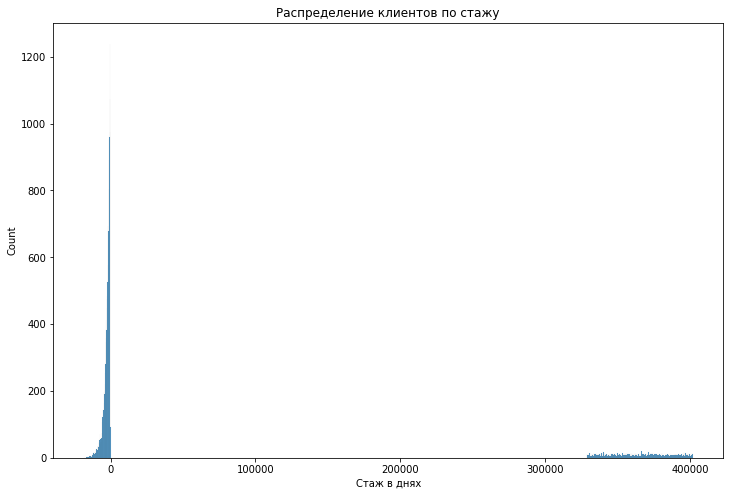

In [42]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

ax = sns.histplot(x="days_employed", data=df)
ax.set_xlabel("Стаж в днях")
ax.set_title("Распределение клиентов по стажу");

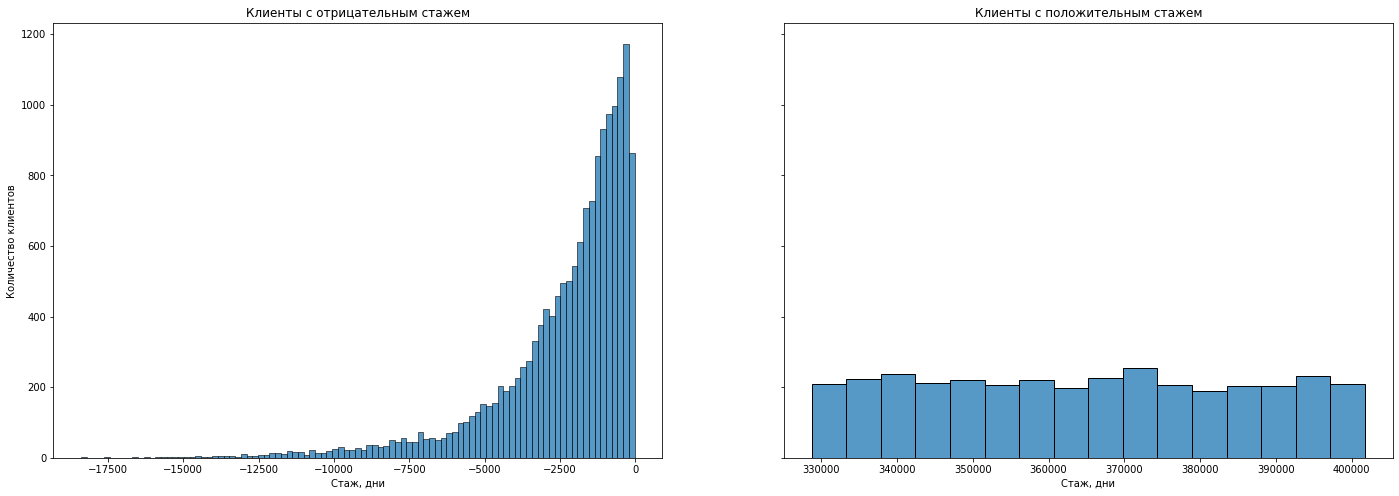

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

sns.histplot(ax=ax[0], x="days_employed", data=df[df["days_employed"] < 0])
ax[0].set_title("Клиенты с отрицательным стажем")
ax[0].set_xlabel("Стаж, дни")
ax[0].set_ylabel("Количество клиентов")

sns.histplot(ax=ax[1], x="days_employed", data=df[df["days_employed"] > 0])
ax[1].set_title("Клиенты с положительным стажем")
ax[1].set_xlabel("Стаж, дни")
ax[1].set_ylabel("Количество клиентов");

Очень странное распределение. Выглядит так, будто информация поступали из разных источников и, возможно, имеет разный смысл: данные чётко делятся на две группы. Большая часть данных имеет отрицательное значение (что само по себе странно для стажа) и имеет колоколообразное распределение. Другая часть &mdash; положительные, распределены более-менее равномерно. Положительные значения по абсолютной величине существенно превосходят отрицательные (401755.400475 против -18388.949901). Между этими группами большой пустой зазор. Отсюда напрашивается вывод, что эти подмножества заданы в разных единицах измерения.

Всё вместе указывает на технический характер ошибки и делает невозможным использование данного параметра в дальнейшем анализе. 

Помимо уже выявленных проблем с этим показателем, наблюдается 2174  неопределённых значений у `days_employed` и `total_income`: в таблице 21525 строк, но `days_employed` и `total_income` имеется только по 19351.

Интересная закономерность: не существует строк, в которых был бы только один пропуск. Если `NaN` присутствует в строке, то в `days_employed` и `total_income` одновременно:

In [44]:
set(df[df["days_employed"].isnull()].index) ^ set(df[df["total_income"].isnull()].index)

set()

Можно было бы предположить, что эти клиенты не имели официального стажа и дохода. Но среди них есть и госслужащие и пенсионеры, так что эта гипотеза несостоятельна. Это именно ошибка. Судя по количенству пропусков (2174 совпадающих пропуска в двух признаках разом), напрашивается вывод о техническом природе данной ошибки.

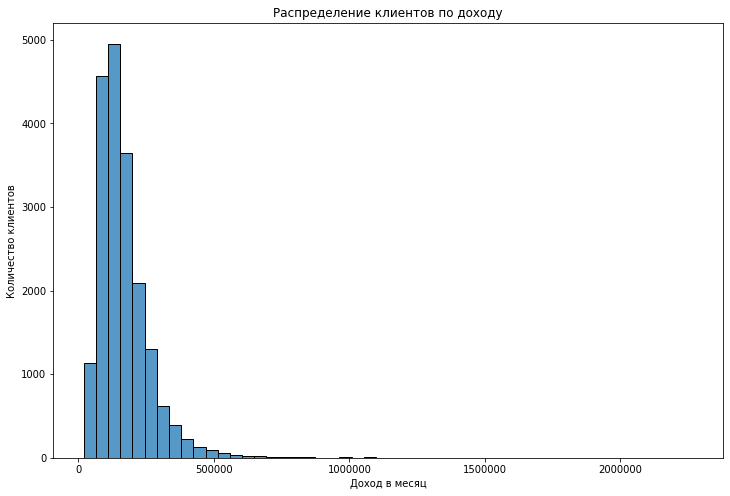

In [45]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

ax = sns.histplot(x="total_income", data=df, bins=50)
ax.set_xlabel("Доход в месяц")
ax.set_ylabel("Количество клиентов")
ax.set_title("Распределение клиентов по доходу");

Распределение доходов выглядит вполне правдоподобно: большое количество людей имеют небольшой доход, но среди них есть и клиенты с доходом на порядки больше среднего. С другой стороны, в данных имеется 2174 пропусков, что составляет $10\%$ от всего набора данных. Просто отбросить такое количество клиентов нельзя. Заполним их медианным значением дохода по группе с одинаковым типом занятости

In [46]:
df["total_income"]=df.groupby("income_type_id")["total_income"].transform(lambda x: x.fillna(x.median()))

Будем пока рассматривать отдельно группу с отрицательным значением стажа и группу с большим положительным стажем. Начнём с первой.

Можно было бы предположить, что отрицательные значения в стаже возникли из-за того, что стаж представлен не абсолютной величиной, а разностью с какой-то константой. Если бы это было среднее, то мы бы имели плотное распределение по обе стороны от нуля. Но у нас нет небольших положиттельных значений. Рассмотрим левый край распределения.

Для удобства временно разделим датафрейм на два, но перед этим заполним пропуски в данных: заполним пропущенные значения средними по типу занятости. 

In [47]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,income_type_id,gender_id,purpose_id
count,"21,525.00","19,351.00","21,525.00","21,525.00","21,525.00","21,525.00","21,525.00","21,525.00","21,525.00","21,525.00"
mean,0.48,"63,046.50",43.50,0.82,0.97,0.08,"165,225.32",4.66,0.34,0.90
std,0.76,"140,827.31",12.23,0.55,1.42,0.27,"98,043.67",1.46,0.47,1.06
min,0.00,"-18,388.95",19.00,0.00,0.00,0.00,"20,667.26",0.00,0.00,0.00
25%,0.00,"-2,747.42",34.00,1.00,0.00,0.00,"107,798.17",3.00,0.00,0.00
50%,0.00,"-1,203.37",43.00,1.00,0.00,0.00,"142,594.40",6.00,0.00,0.00
75%,1.00,-291.10,53.00,1.00,1.00,0.00,"195,549.94",6.00,1.00,2.00
max,5.00,"401,755.40",75.00,4.00,4.00,1.00,"2,265,604.03",7.00,1.00,3.00


In [48]:
df["days_employed"]=df.groupby("income_type_id")["days_employed"].transform(lambda x: x.fillna(x.mean()))

In [49]:
df1 = df[df["days_employed"] < 0]
df2 = df[df["days_employed"] > 0]

In [50]:
df1.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,income_type_id,gender_id,purpose_id
count,"17,667.00","17,667.00","17,667.00","17,667.00","17,667.00","17,667.00","17,667.00","17,667.00","17,667.00","17,667.00"
mean,0.56,"-2,353.02",40.04,0.80,0.97,0.09,"171,796.91",4.81,0.37,0.90
std,0.79,"2,188.90",10.32,0.55,1.44,0.28,"101,036.45",1.58,0.48,1.06
min,0.00,"-18,388.95",19.00,0.00,0.00,0.00,"21,367.65",1.00,0.00,0.00
25%,0.00,"-3,004.62",32.00,0.00,0.00,0.00,"112,527.65",3.00,0.00,0.00
50%,0.00,"-1,885.78",39.85,1.00,0.00,0.00,"148,235.14",6.00,0.00,0.00
75%,1.00,-843.31,48.00,1.00,1.00,0.00,"201,813.01",6.00,1.00,2.00
max,5.00,-24.14,75.00,4.00,4.00,1.00,"2,265,604.03",7.00,1.00,3.00


In [51]:
df2.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,income_type_id,gender_id,purpose_id
count,"3,858.00","3,858.00","3,858.00","3,858.00","3,858.00","3,858.00","3,858.00","3,858.00","3,858.00","3,858.00"
mean,0.09,"365,004.22",59.36,0.91,0.99,0.06,"135,131.94",4.00,0.18,0.92
std,0.34,"19,914.74",6.33,0.51,1.31,0.23,"76,042.56",0.09,0.39,1.06
min,0.00,"328,728.72",22.00,0.00,0.00,0.00,"20,667.26",0.00,0.00,0.00
25%,0.00,"348,799.95",56.00,1.00,0.00,0.00,"87,162.98",4.00,0.00,0.00
50%,0.00,"365,003.49",60.00,1.00,0.00,0.00,"118,514.49",4.00,0.00,1.00
75%,0.00,"380,759.82",64.00,1.00,2.00,0.00,"162,144.55",4.00,0.00,2.00
max,4.00,"401,755.40",74.00,4.00,4.00,1.00,"735,103.27",4.00,1.00,3.00


In [52]:
df1[df1["days_employed"] < -15000]

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,income_type_id,gender_id,purpose_id
1539,0,"-15,785.68",59.00,0,4,0,"119,563.85",6,0,0
3974,0,"-15,835.73",64.00,1,1,0,"96,858.53",3,0,3
4299,0,"-17,615.56",61.00,1,0,0,"122,560.74",3,0,0
4321,0,"-15,773.06",61.00,1,1,0,"205,868.59",6,0,3
5581,0,"-15,079.22",55.00,1,0,0,"178,761.37",2,0,0
7329,0,"-16,593.47",60.00,0,0,0,"124,697.85",6,0,2
7731,0,"-15,618.06",64.00,1,0,0,"296,525.36",3,0,2
15675,0,"-15,410.04",65.00,0,0,0,"188,800.07",6,0,0
16335,1,"-18,388.95",61.00,1,0,0,"186,178.93",6,0,0
16825,0,"-16,119.69",64.00,1,0,0,"91,527.69",6,0,0


Видно, что самым большим по абсолютной величине стажем обладают люди солидного возраста. Напротив, возле нуля преобладает молодёжь. Исключения есть, но это можно считать выбросами, в конце концов, можно представить человека, дожившего до средних лет и нигде толком не работавшего, получающего доход из других источников. Стало быть, логично предположить, что для данной группы имеет значение только абсолютная величина стажа: по какой-то причине, очевидно, технической, знак стажа сменился на отрицательный. 

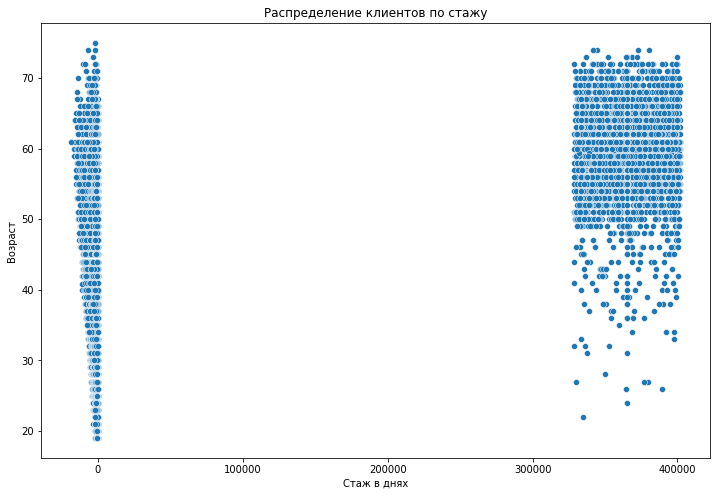

In [53]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

ax = sns.scatterplot(data=df, x="days_employed", y="dob_years")
ax.set_xlabel("Стаж в днях")
ax.set_ylabel("Возраст")
ax.set_title("Распределение клиентов по стажу");

Осталось разобраться со второй группой. Проблема в том, что в ней не только более высокие значения стажа, что можно было бы решить простым масштабированием и сдвигом, но и совершенно другой характер распределения: равномерное вместо спадающего (условно "половинка колокола"). 

Может ли это быть связано с однородностью группы? Ведь, как мы уже выяснили все члены этой группы неработающие пенсионеры?

In [54]:
df2['dob_years'].describe()

count   3,858.00
mean       59.36
std         6.33
min        22.00
25%        56.00
50%        60.00
75%        64.00
max        74.00
Name: dob_years, dtype: float64

In [55]:
df2["days_employed"].median() 

365003.4912448612

Если сделать предположение, что стаж в группе пенсионеров выражен не в днях, а в часах, медианное значение в днях составит 15217, что близко к максимальному по абсолютной величине стажу непенсионеров. Что само по себе логично.

Таким образом, чтобы починить данные по стажу нам нужно взять по модулю стаж из df1 и поделить стаж из df2 на 24 и свести всё обратно в общую таблицу

У группы с наибольшим отрицательным стажем больше 14000 дней (по модулю) как раз медианный возраст 60 лет. Тогда в нашем предположении достаточно привести медианный стаж пенсионеров к медианному стажу этой группы.

In [56]:
df1["days_employed"] = df1["days_employed"].apply(np.abs)
df2["days_employed"] = df2["days_employed"]/24
df = df1.append(df2)

In [57]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,income_type_id,gender_id,purpose_id
count,"21,525.00","21,525.00","21,525.00","21,525.00","21,525.00","21,525.00","21,525.00","21,525.00","21,525.00","21,525.00"
mean,0.48,"4,657.15",43.50,0.82,0.97,0.08,"165,225.32",4.66,0.34,0.90
std,0.76,"5,326.23",12.23,0.55,1.42,0.27,"98,043.67",1.46,0.47,1.06
min,0.00,24.14,19.00,0.00,0.00,0.00,"20,667.26",0.00,0.00,0.00
25%,0.00,"1,025.55",34.00,1.00,0.00,0.00,"107,798.17",3.00,0.00,0.00
50%,0.00,"2,326.50",43.00,1.00,0.00,0.00,"142,594.40",6.00,0.00,0.00
75%,1.00,"5,347.02",53.00,1.00,1.00,0.00,"195,549.94",6.00,1.00,2.00
max,5.00,"18,388.95",75.00,4.00,4.00,1.00,"2,265,604.03",7.00,1.00,3.00


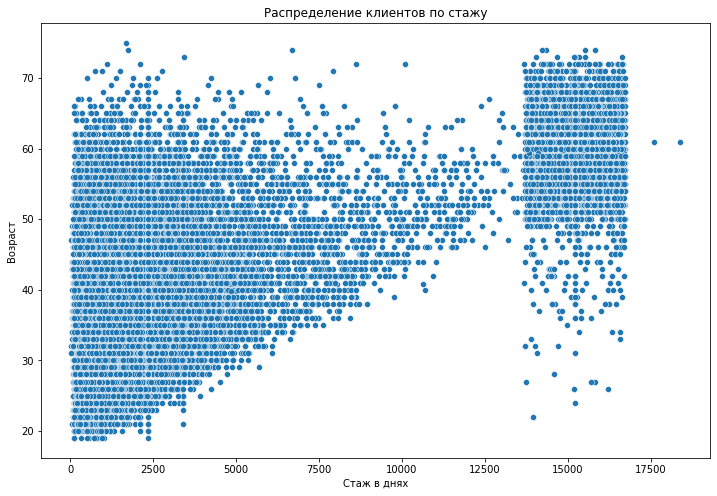

In [58]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

ax = sns.scatterplot(data=df, x="days_employed", y="dob_years")
ax.set_xlabel("Стаж в днях")
ax.set_ylabel("Возраст")
ax.set_title("Распределение клиентов по стажу");

#### Вывод

Признак "стаж" был сильно искажён, видимо, по техническим причинам.  

Признак "доход" выглядит правдоподобно, его можно использовать при анализе. Необходимо только заполнить выявленые ранее пропуски.

## Проверка гипотезы о предсказательной силе параметров "дети" и "семейное положение"

Прежде всего, нам необходимо найти ответ на вопрос, влияют ли семейное положение и количество детей на шанс невозврата кредита. Наиболее простым и очевидным критерием будет количество невозвратов кредитов в группах клиентов построенных по исследуемым показателям. 

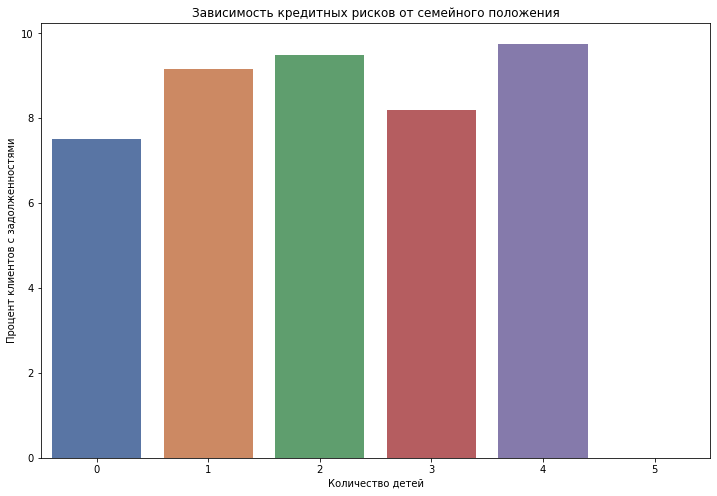

In [59]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

data = (df.groupby("children").agg({"debt": "mean"}) * 100)
data.reset_index(inplace=True)

ax = sns.barplot(
    x="children",
    y='debt',
    data=data,
    palette="deep",
)
ax.set_title("Зависимость кредитных рисков от семейного положения")
ax.set_xticks(np.arange(0, 6, 1))
ax.set_ylabel("Процент клиентов с задолженностями")
ax.set_xlabel("Количество детей");

Подсчитаем количество многодетных клиентов с 5 детьми:

In [60]:
df[df['children']>4]['children'].count()

9

Из графика видно, что количество детей не дают я уверенного прогноза невозврата кредита. Количество детей имеет значение только когда детей больше четверых: они несут минимальные риски. К сожалению, в выборке их всего $9$.

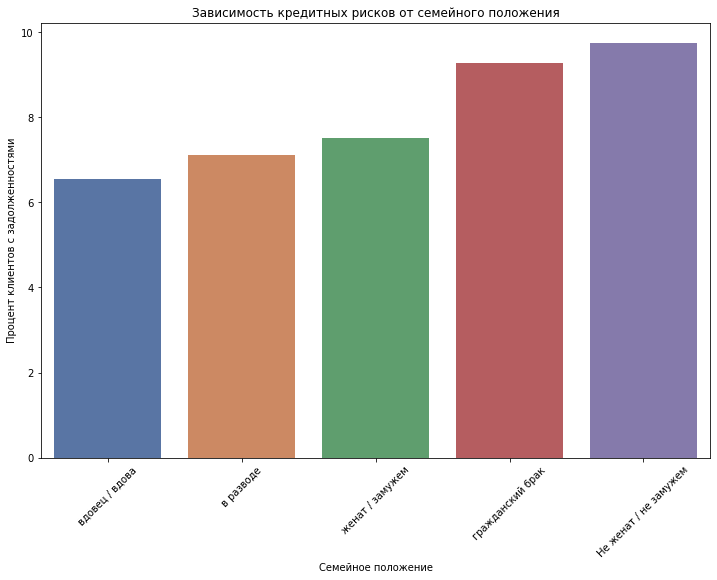

In [61]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
data = (df.groupby("family_status_id").agg({"debt": "mean"}) * 100)

data = data.merge(family_status_dict, left_index=True, right_index=True)
data.sort_values('debt', inplace=True)
    
ax = sns.barplot(
    x="family_status",
    y="debt",
    data=data,
    palette="deep",
)
ax.set_title("Зависимость кредитных рисков от семейного положения")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Процент клиентов с задолженностями")
ax.set_xlabel("Семейное положение");

Видно, что все клиенты разделились на три неравные группы:
- вдовы/вдовцы с наименьшими рисками (риск в районе $6.5\%$),
- женатые/замужние + "в разводе" с чуть большими рисками ($7-7.5\%$) и 
- неженатые/незамужние + находящиеся в гражданском браке с наибольшими рисками ($>9\%$).

Подсчитаем объём каждой из групп: 

In [62]:
def family_status_count(categories):
    count = 0
    for category in categories:
        idx = family_status_dict[family_status_dict["family_status"]==category].index.values[0]
        count += df[df["family_status_id"]==idx]["family_status_id"].count()
    return count

In [63]:
print(f"Объём группы с минимальными рисками: {family_status_count(['вдовец / вдова'])}")
print(f"Объём группы со средними рисками: {family_status_count(['женат / замужем', 'в разводе'])}")
print(f"Объём группы с высокими рисками: {family_status_count(['гражданский брак', 'Не женат / не замужем'])}")

Объём группы с минимальными рисками: 960
Объём группы со средними рисками: 13575
Объём группы с высокими рисками: 6990


Итак, у нас есть 960 клиентов с рисками <7%, большую группу в 13575 человек с рисками от 7 до 7,5% и 6990 заёмщиков с рисками выше 9%.

### Вывод

Из построенного графика видно, что количество детей и семейное положение не дают я уверенного прогноза невозврата кредита. 

Количество детей имеет значение только когда детей больше четверых: такие заёмщики, очевидно, более добросовестны. К сожалению, в выборке их всего $8$.

В случае же семейного положения, мы получили большую группу клиентов с высокими рисками (более $9\%$) и оставшееся большинство ($2/3$ от всей выборки) с рисками в пределах $6.5-7.5\%$. Судить об эффективности данного показателя можно, зная уровни риска, приемлемые для бизнеса.

## Проверка влиянии возраста, дохода и образования на возврат кредита

Семейное положение и количество детей не показали хороших корреляций с кредитоспособностью для широких масс заёмщиков, так что попробуем найти более подходящие. Традиционно, хорошими показателями считаются возраст, доход и образования. Проверим это.

Разделим всех клиентов на 10 возростных групп. После этого внутри каждой группы расчитаем процент клиентов с пробелалми с погашением кредита.

In [64]:
bins = np.linspace(df["dob_years"].min(), df["dob_years"].max()+1, num=4)
df["age_group"] = pd.cut(df["dob_years"], bins=bins, right=False)
df["age_group"] = df["age_group"].apply(
    lambda x: round((x.left + x.right) / 2)
)
df["age_group"] = df["age_group"].astype('str')

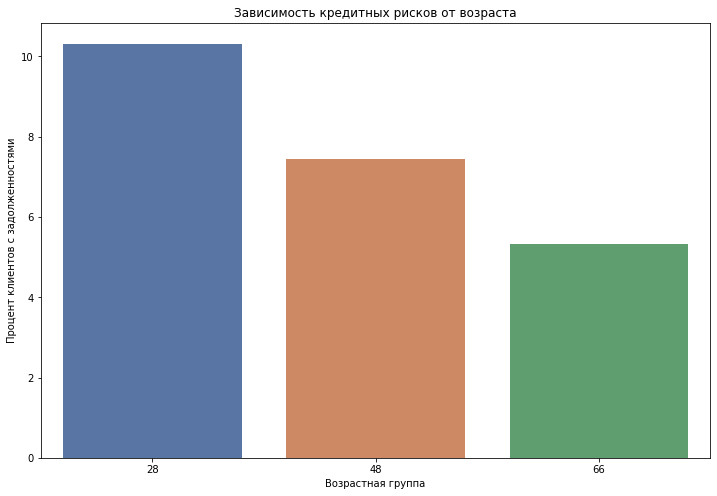

In [65]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
data = (df.groupby("age_group").agg({"debt": "mean"}) * 100)
data["age_group"] = data.index

ax = sns.barplot(
    x="age_group",
    y="debt",
    data=data,
    palette="deep",
)
ax.set_title("Зависимость кредитных рисков от возраста")
ax.set_ylabel("Процент клиентов с задолженностями")
ax.set_xlabel("Возрастная группа");

Из графика видна прекрасная обратная корреляция между возрастом заёмщика и кредитными рисками.

Проделаем такие же построения для дохода

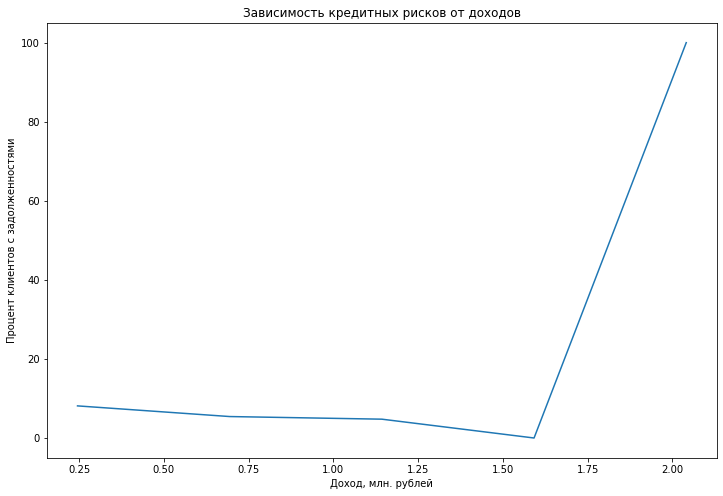

In [66]:
# разделим всех клиентов на 20 групп по доходу
bins = np.linspace(
    df["total_income"].min(), df["total_income"].max(), num=6
)
df["income_group"] = pd.cut(df["total_income"], bins=bins, right=False)
df["income_group"] = df["income_group"].apply(
    lambda x: (x.left + x.right) / 2 / 1e6
)

fig = plt.gcf()
fig.set_size_inches(12, 8)
data = df.groupby("income_group").agg({"debt": "mean"})  * 100
data.reset_index(inplace=True)

ax = sns.lineplot(
    x="income_group",
    y="debt",
    data=data,
    palette="deep",
)
ax.set_title("Зависимость кредитных рисков от доходов")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Процент клиентов с задолженностями")
ax.set_xlabel("Доход, млн. рублей");

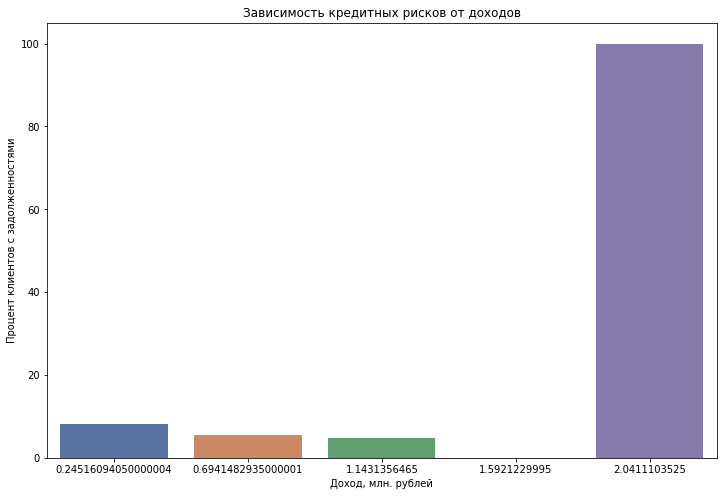

In [67]:
# разделим всех клиентов на 20 групп по доходу
bins = np.linspace(
    df["total_income"].min(), df["total_income"].max(), num=6
)
df["income_group"] = pd.cut(df["total_income"], bins=bins, right=False)
df["income_group"] = df["income_group"].apply(
    lambda x: (x.left + x.right) / 2 / 1e6
)

fig = plt.gcf()
fig.set_size_inches(12, 8)
data = df.groupby("income_group").agg({"debt": "mean"})  * 100
data.reset_index(inplace=True)

ax = sns.barplot(
    x="income_group",
    y="debt",
    data=data,
    palette="deep",
)
ax.set_title("Зависимость кредитных рисков от доходов")
ax.set_ylabel("Процент клиентов с задолженностями")
ax.set_xlabel("Доход, млн. рублей");

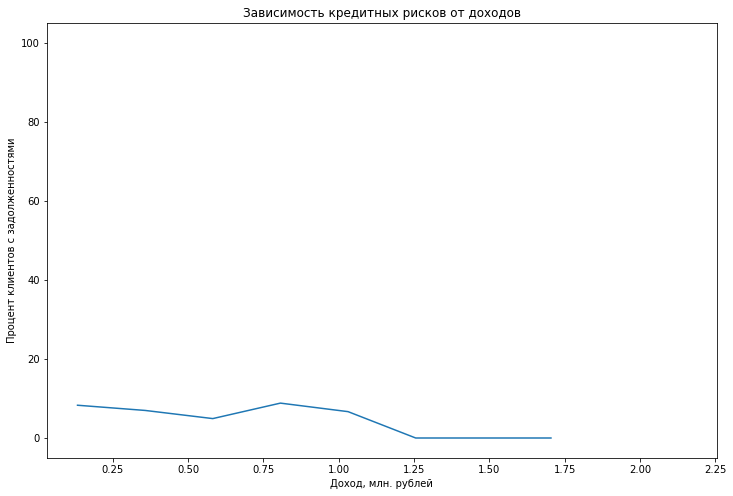

In [68]:
# разделим всех клиентов на 10 групп по доходу
bins = np.linspace(
    df["total_income"].min(), df["total_income"].max(), num=11
)
df["income_group"] = pd.cut(df["total_income"], bins=bins, right=False)
df["income_group"] = df["income_group"].apply(
    lambda x: (x.left + x.right) / 2 / 1e6
)

fig = plt.gcf()
fig.set_size_inches(12, 8)
data = df.groupby("income_group").agg({"debt": "mean"})  * 100
data.reset_index(inplace=True)

ax = sns.lineplot(
    x="income_group",
    y="debt",
    data=data,
    palette="deep",
)
# ax.set(ylim=(-1, 16), xlim=(0, 1.8))
ax.set_title("Зависимость кредитных рисков от доходов")
ax.set_ylabel("Процент клиентов с задолженностями")
ax.set_xlabel("Доход, млн. рублей");

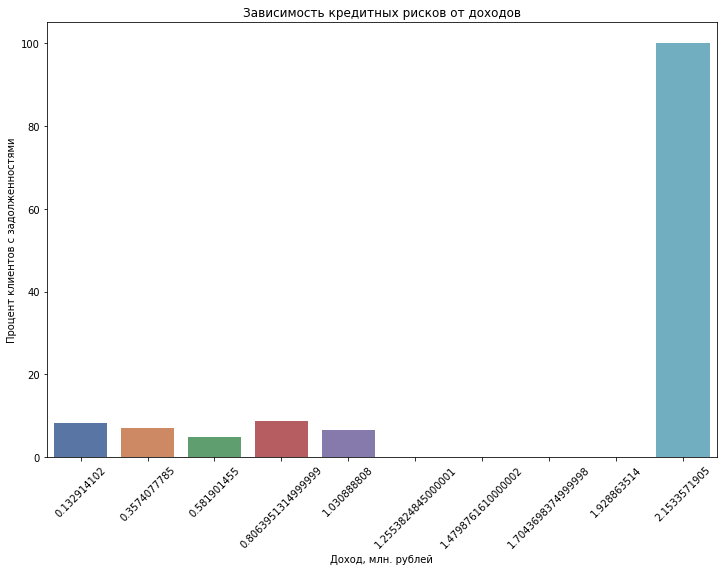

In [69]:
bins = np.linspace(
    df["total_income"].min(), df["total_income"].max(), num=11
)
df["income_group"] = pd.cut(df["total_income"], bins=bins, right=False)
df["income_group"] = df["income_group"].apply(
    lambda x: (x.left + x.right) / 2 / 1e6
)

fig = plt.gcf()
fig.set_size_inches(12, 8)
data = df.groupby("income_group").agg({"debt": "mean"})  * 100
data.reset_index(inplace=True)

ax = sns.barplot(
    x="income_group",
    y="debt",
    data=data,
    palette="deep",
)
# ax.set(ylim=(-1, 16), xlim=(0, 1.8))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Зависимость кредитных рисков от доходов")
ax.set_ylabel("Процент клиентов с задолженностями")
ax.set_xlabel("Доход, млн. рублей");


График зависимости кредитных рисков от доходов показывает, что существует очень надёжная группа заёмщиков: клиенты с доходом выше $~1.15$ миллионов рублей, которые не имели проблем с кредитами. Также из графика следует, что люди с доходом около 1 миллиона имеют наибольшие проблемы с обслуживанием долга. Из остальных клиентов наименьшие риски несут люди с доходом около 0.5 миллиона рублей.

Можно предположить, что клиенты с высокими доходами в принципе не имеют проблем с обслуживанием долга. Примыкающая же к ним гркппа со средне-высокими доходами имеют амбиции потреблять так же как и первые, но не имеют возможности обеспечить такое потребление реальными доходами. Группа со средними доходами получают достаточно. чтобы обслуживать умеренные долги и проявляют осторожность в расходах. Группа же с низкими доходами просто наиболее финансово неустойчива.  

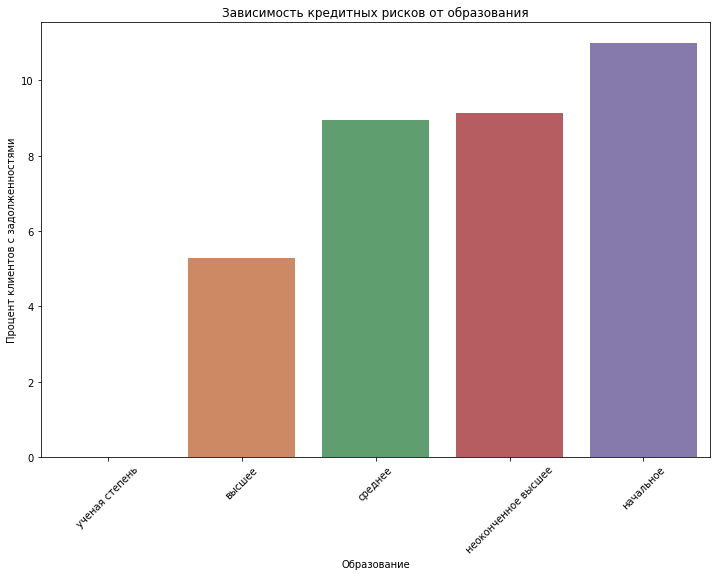

In [70]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

data = (df.groupby("education_id").agg({"debt": "mean"}) * 100)
data.reset_index(inplace=True)
data.sort_values('debt', inplace=True)
data = data.merge(education_dict)

ax = sns.barplot(
    x="education",
    y="debt",
    data=data,
    palette="deep",
)

ax.set_title("Зависимость кредитных рисков от образования")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xticks(np.arange(0, 5, 1))
ax.set_ylabel("Процент клиентов с задолженностями")
ax.set_xlabel("Образование");

Как и в случае возраста, прослеживается чёткая связь между уровнем образования и рисками по кредиту: чем выше образовани, тем ниже риски. Наиболее рискованными заёмщиками являются клиенты с начальным образованием, наименее &mdash; с вышим. Немногочисленная группа клиентов с научными степенями (6 человек) практически не создаёт кредитных рисков.

## Влияние цели кредита на кредитные риски

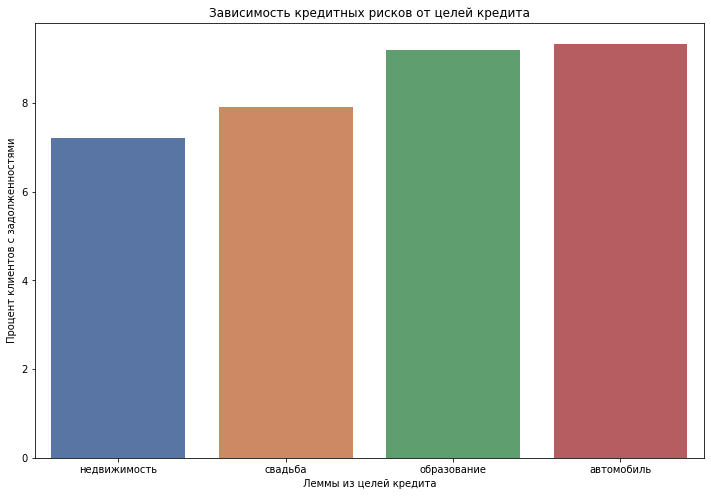

In [71]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

data = (df.groupby("purpose_id").agg({"debt": "mean"}) * 100)
data.sort_values('debt', inplace=True)
data = data.merge(purpose_dict, left_index=True, right_index=True)

# data = df[targets + ["debt"]].groupby("debt").sum()
# data.reset_index(inplace=True)
# data=data.merge(purpose_dict)
# data.sort_values("debt", inplace=True)

ax = sns.barplot(
    x='purpose',
    y='debt',
    data=data,
    palette="deep",
)

ax.set_title("Зависимость кредитных рисков от целей кредита")
# ax.set_xticklabels(targets, rotation=45)
# ax.set_xticks(np.arange(0, 5, 1))
ax.set_ylabel("Процент клиентов с задолженностями")
ax.set_xlabel("Леммы из целей кредита");

На графике видно, что цели кредита связанные с леммами "автомобиль" и "образование"несут самые высокие риски. Можно предположить, что люди которые разбили машины и не осилили образование менее пунктуальны в выплете долга под эти траты.

Цель "недвижимость"сопряжена с наименьшими рисками. Это серьёзное и ответственное вложение, и заёмщики серьёзно относятся к погашению кредита.

"Свадьба" находится между ними, чуть тяготея к низкорисковой недвижимости.

### Вывод

Из построенного графика следует, что наибольший риск несут кредиты взятые под цели, связанные с автомобилем и образованием. Наименее рискованы кредиты, связанные с недвижимостью.

## Итоги исследования

В ходе исследования был проверен ряд гипотез. Основные:
- семейное положение предсказывает кредитные риски
- количество детей предсказывает кредитные риски

И альтернативные:
- доход предсказывает кредитные риски
- возраст предсказывает кредитные риски
- цели кредита предсказывают кредитные риски

Также была предпринята попытка объективизировать подбор параметров для предсказания кредитных рисков.

Проверка основных гипотез показала крайне низкую эффективность показателя "количество детей": он имеет предсказательную силу лишь очень маленькой группы многодетных клиентов.

Семейное положение позволило разделить клиентов на три группы. Этот показатель можно считать эффективным. 

Доход как предиктор кредитных рисков также показал свою эффективность, выявив группы практически безрисковые клиенты с высоким доходом и высокорисковую группу клиентов с доходом около 1 млн. рублей. Этот результат не вполне интуитивен, а потому ценен.

Возраст продемонстрировал отчётливую корреляцию с кредитными рисками: с росто возраста заёмщика риски в целом снижаются. При этом наибольшие риски несут клиенты в возрасте до 30 лет

Анализ целей кредита показал, что наименьшие риски несут кредиты связанные с покупкой и ремонтом недвижимости, а наибольше &mdash; связанные с авто и образованием.